In [35]:
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text

import pandas as pd
import numpy as np


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re
import string

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from official.nlp import optimization

In [44]:
path = "E:/LOMBA/Kaggle/Comp/Coommon readilbility/"
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

STOPWORDS = set(stopwords.words("english"))
def text_cleaning(text):
    text_clean = " ".join([word for word in word_tokenize(text) if not word in STOPWORDS])
    text = re.sub("\s+"," ", text_clean) # remove extra spaces
    text = ''.join([k for k in text if k not in string.punctuation]) # remove punctuation
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip() # remove unnecessary literals and Perform Case Normalization
    text = ''.join([i for i in text if not i.isdigit()])
    return text

target = train.target.to_numpy()
text = train.excerpt.to_numpy()

In [45]:
fold = KFold(5, shuffle=True, random_state=42)
cv = list(fold.split(txt_clean, target))

#  Training  Albert Scarth

In [46]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "http://tfhub.dev/tensorflow/albert_en_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/albert_en_base/3",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]

In [47]:
embedding_model = tf.keras.Model(text_input, pooled_output)
sentences = tf.constant(["(your text here)", "how your day"])
print(embedding_model(sentences).shape)

(2, 768)


In [48]:
def albert_base_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]    
    net = tf.keras.layers.Dropout(0.1)(pooled_output)
    net = tf.keras.layers.Dense(1, activation=None, name='regressor')(net)
    model = tf.keras.models.Model(inputs=text_input, outputs=net, name="model_albert_trainable")
    return model

In [49]:
albert_model = albert_base_model()
albert_model.summary()

Model: "model_albert_trainable"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_6 (KerasLayer)      {'input_type_ids': ( 0           input_8[0][0]                    
__________________________________________________________________________________________________
keras_layer_7 (KerasLayer)      {'encoder_outputs':  11683584    keras_layer_6[1][0]              
                                                                 keras_layer_6[1][1]              
                                                                 keras_layer_6[1][2]              
_____________________________________________________________________________

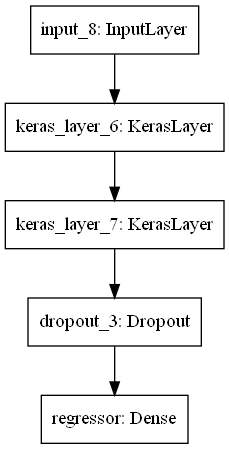

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(albert_model)

In [51]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(tf.data.Dataset.range(len(train_y))).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [52]:
loss = "mean_squared_error"
metrics = tf.keras.metrics.RootMeanSquaredError()

In [53]:
albert_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
rmses = []
for tr_idx, val_idx in cv: 

    x_tr, x_va = np.array(txt_clean)[tr_idx], np.array(txt_clean)[val_idx]
    y_tr, y_va = target[tr_idx], target[val_idx]
        
        
    # Training
    albert_model.fit(x=x_tr,
                     y=y_tr,
                     validation_data=(x_va, y_va),
                     epochs=3)
        
    y_pred = albert_model.predict(x_va)
    rmse =  np.sqrt(mean_squared_error(y_va, y_pred))
    rmses.append(rmse)
    break

        
print("\n", "Mean Fold RMSE:", np.mean(rmses))   
pd.Series(albert_model.predict(x_va)).hist()

Epoch 1/3
27/71 [==========>...................] - ETA: 2:58 - loss: 1.3464 - root_mean_squared_error: 1.1603

In [ ]:
loss, accuracy = albert_model.evaluate(x_va)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
albert_model.save("saved_model")